# HadISD Analysis

Author: Ilan Valencius

Institution: Boston College

Purpose: Analyze the Hadley Center Integrated Surface Dataset with a focus on wind properties

Created: 10-25-2023

## Download HadISD

Download links are extracted from the [Hadley Center Website](https://www.metoffice.gov.uk/hadobs/hadisd/v331_202309p/download.html) and stored in ```HadISD_download_links.txt```

In [ ]:
# ! sh /wind-analysis/download_HadISD.sh

## Library Imports for analysis

In [1]:
import os
from tqdm import tqdm, trange
# import sys
from glob import glob
# Better debugging printing
from icecream import ic
# Working with data
import xarray as xr
import numpy as np
import pandas as pd
import regionmask
import scipy.stats as stats
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
# Parallel processing
from joblib import Parallel, delayed, parallel_config
# Working with geographic datatypes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Kriging the data
from pykrige.ok import OrdinaryKriging
# Plotting Options
import scienceplots
plt.style.use(["science", "nature"]) # Can also add the style: "grid"
# plt.rcParams.update({
#     "font.family": "sans serif",   # specify font family here
#     "font.serif": ["Helvetica"],  # specify font here
#     "font.size":11})          # specify font size here

# Merge HadISD Sites by US State

## Pipeline:
1. Load station metadata
2. Mask all stations by US state
3. For each state, load these files and combine into one netcdf file

In [2]:
# Variables commented out are KEPT
drop_vars = [
        'temperatures',
        'dewpoints',
        'slp',
        'stnlp',
        # 'windspeeds',
        # 'winddirs',
        'total_cloud_cover',
        'low_cloud_cover',
        'mid_cloud_cover',
        'high_cloud_cover',
        'precip1_depth',
        'precip2_depth',
        'precip3_depth',
        'precip6_depth',
        'precip9_depth',
        'precip12_depth',
        'precip15_depth',
        'precip18_depth',
        'precip24_depth',
        'cloud_base',
        # 'wind_gust',
        'past_sigwx1',
        'input_station_id',
        'quality_control_flags',
        'flagged_obs',
        'reporting_stats'
]

# Define function to extract data from netcdf files
def load_file(f):
    ds = xr.open_dataset(f, drop_variables=drop_vars)
    ds_id = ds.squeeze().expand_dims(dim={"station_id" : [ds.attrs["station_id"]]}, axis=1)
    return ds_id.resample(time="1D").mean() # monthly average

In [ ]:
# Load station metadata
metadata = pd.read_table("../data/HadISD/hadisd_station_info_v331_202309p.txt", delim_whitespace=True, 
                         header=None, 
                         names=["station", "lat", "lon", "elevation [m]"])
# Coerce to xarray dataset for easy masking
stations_xr = xr.Dataset(
    data_vars=dict(
        lat=(["station"], metadata["lat"]),
        lon=(["station"], metadata["lon"]),
        elevation=(["station"], metadata["elevation [m]"])
    ),
    coords=dict(
        station=metadata["station"],
    )
)
# Load regionmask for US States
states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
# Mask states
states_mask = states.mask(stations_xr)

# Plot of all masked stations
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={"projection":ccrs.PlateCarree()})
fig.suptitle("Masked Stations")
cmap = cm.jet
cmap.set_bad('black',0.1) # For stations that aren't masked
c = ax.scatter(stations_xr['lon'], stations_xr['lat'], c=states_mask.values, 
           transform=ccrs.PlateCarree(), cmap=cmap)
ax.coastlines()
plt.colorbar(c, orientation='horizontal', label="Mask Value")
plt.show()

# Create save directory
write_dir = '../data/HadISD/us-states/'
if not os.path.exists(write_dir):
    os.makedirs(write_dir)


# Loop through US states and save combined dataset
for key in trange(len(states), desc="Masking States and Extracting Data"):
    # Select stations from the state
    stations_state = stations_xr.where(states_mask == key, drop=True)
    # Extract ids
    station_ids = stations_state["station"].values
    # Extract all station files
    files = glob('../data/HadISD/raw/*.nc')
    # Filter station files to only include stations within the state
    good_files = [
        f for f in files if f.split('_')[-1][:-3] in station_ids
    ]
    if len(good_files) == 0:
        continue
    # Load all station data for the state
    with parallel_config(backend='threading', n_jobs=8):
        xr_processed = Parallel()(
            delayed(load_file)(f) for f in good_files
        )
        ds = xr.concat(xr_processed, dim="station_id")
        ds.to_netcdf(write_dir+states[key].name+'.nc')

### Merge HadISD sites by IPCC region [*Not implemented*]

# Global stilling trend

## Extract stations from Zeng et al. (2019)

In [ ]:
zeng = pd.read_excel("../data/Zeng_data/Zeng_sup_data_2.xlsx")
metadata = pd.read_table(
    "../data/HadISD/hadisd_station_info_v331_202309p.txt", 
    delim_whitespace=True, 
    header=None, 
    names=["station", "lats", "lons", "elev (m)"]
)
merge_keys = ["lats", "lons", "elev (m)"]

merged = zeng.merge(metadata, on=merge_keys, how='outer', indicator=True)
# Stations with a match
match = merged[merged['_merge'] == 'both']
# Get all rows in zeng without a match
no_match = merged[merged['_merge'] == 'left_only']
metadata_no_match = merged[merged['_merge'] == 'right_only']
# 302 bad stations, 299 unique lon indices
match2 = pd.merge_asof(
    no_match.sort_values('lats'), metadata_no_match.sort_values('lats'), on='lats'
)
# Drop duplicates (2 stations not matched)
match2 = match2.drop_duplicates(keep='first')
# Get all station ids
zeng_ids = np.concatenate((match['station'].values, match2['station_y'].values))
zeng_ids = np.unique(zeng_ids)
print(f'Stations missing: {len(zeng)-len(zeng_ids)}')

# Load all station files
files = glob('../data/HadISD/raw/*.nc')
# Filter station files to only include stations within the state
good_files = [
    f for f in files if f.split('_')[-1][:-3] in zeng_ids
]
# Load all station data for the state
with parallel_config(backend='threading', n_jobs=8):
    xr_processed = Parallel()(
        delayed(load_file)(f) for f in good_files
    )
    ds = xr.concat(xr_processed, dim="station_id")
    ds.to_netcdf('../data/HadISD/Zeng_2019.nc')

## Load stations from Zeng et al. (2019) and plot global stilling

100%|██████████| 300/300 [00:28<00:00, 10.43it/s]


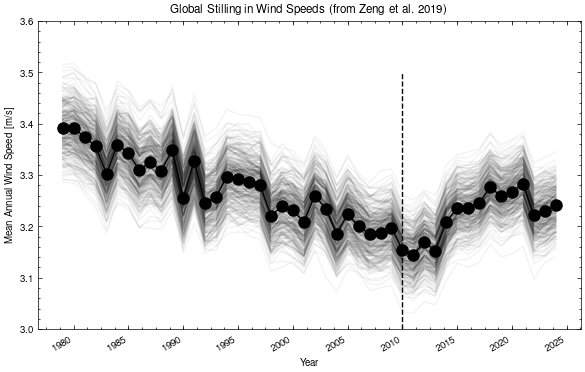

In [9]:
z_r = xr.open_dataset('../data/HadISD/Zeng_2019.nc', chunks={"time": 1000})
z = z_r.where((z_r >= 0).compute())
z_1Y = z.resample(time="1Y").mean()
z_1978 = z_1Y.sel(time=slice("1978-01-01", None))

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
# for station in tqdm(z_1Y['station_id']):
#     z_1978.sel(station_id=station)['windspeeds'].plot(ax=ax, alpha=0.01, color='k')
# Get number of sites for a 40% sample
num40 = int(len(z_1978['station_id'])*0.4)
for i in trange(300):
    # Get random sample
    sample = np.random.choice(z_1978['station_id'], size=num40, replace=False)
    # Plot by year 
    z_1978.sel(station_id=sample)['windspeeds'].mean("station_id").plot(ax=ax, alpha=0.05, color='k')
z_1978.mean("station_id")['windspeeds'].plot(ax=ax, color='k', marker='o', markersize=8)
ax.vlines(z_1978.time[31], ymin=3, ymax=3.5, color='k', linestyles='--')
ax.set_ylim([3, 3.6])
ax.set_xlabel('Year')
ax.set_ylabel('Mean Annual Wind Speed [m/s]')
plt.title("Global Stilling in Wind Speeds (from Zeng et al. 2019)")
plt.savefig('../plots/HadISD/global_stilling.png', dpi=300, bbox_inches='tight')

# State Analysis

## Define functions to make plots

In [2]:
def plot_avg_windspeeds(ds, region, save_path):
    fig, ax = plt.subplots(figsize=(7,4))

    # Get mean of all sites per state
    for state in ds.state:
        state_means = ds.sel(state=state).mean(
            dim=["station_id"]
        ).resample(time="1Y").mean()
        state_means["windspeeds"].plot(
            ax=ax, label=state.values, alpha=0.6
        )
        
    # Add mean of all states
    all_state = ds.mean(dim=["station_id", "state"]).resample(time="1Y")
    all_mean = all_state.mean()
    all_std = all_state.std()
    all_mean["windspeeds"].plot(
        ax=ax, label=region, color='k', linewidth=3#, linestyle='dotted'
    )
    ax.fill_between(
        all_mean.time, 
        all_mean["windspeeds"]-all_std["windspeeds"], 
        all_mean["windspeeds"]+all_std["windspeeds"], 
        alpha=0.1, color='k'
    )
    # Add legend
    ax.legend()
    # Add labels
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Wind Speed [m/s]")
    plt.title(f'{region} Mean Windspeeds')
    plt.savefig(f'{save_path}/mean_windspeeds.png', dpi=300)

def plot_decadal_distribution(ds, region, save_path):    
    # Get starting time
    start = ds.time[0]
    start_year = (start.dt.year.values//10)*10 # Get starting year of first sdecade
    # Get ending time
    end = ds.time[-1]
    # Get number of years
    num_years = (end - start).dt.days / 365.25
    # Get number of decades
    num_decades = int(num_years // 10) + 1
    
    # Histogram of all decades
    fig, ax = plt.subplots(figsize=(7,4))
    for i in range(num_decades):
        # Get decade
        decade = ds.sel(time=slice(f'{start_year+(i*10)}-01-01', f'{start_year+(i*10)+10}-01-01'))
        # Mean of all states in decade
        ax.hist(decade['windspeeds'].values.flatten(), bins=300, alpha=0.5, label=f'{start_year+(i*10)}\'s', density=True, histtype='step')
    ax.legend()
    ax.set_xlim(0, 12)
    ax.set_ylabel('Probability Density')
    ax.set_xlabel('Windspeed [m/s]')
    plt.title(f'{region} Decadal Distribution of Windspeeds')
    plt.savefig(f'{save_path}/decade_histogram.png', dpi=300)
    
    # Now plot gamma distributions
    fig, ax = plt.subplots(figsize=(7,4))
    for i in range(num_decades):
        # Get decade
        decade = ds.sel(time=slice(f'{start_year+(i*10)}-01-01', f'{start_year+(i*10)+10}-01-01'))
        # Mean of all states in decade
        speeds = decade['windspeeds'].values.flatten()
        good_speeds = speeds[speeds > 0] # all variables must be > 0 
        xx = np.linspace(0,12,1000)
        ag,bg,cg = stats.gamma.fit(good_speeds, floc=0)
        pdf_gamma = stats.gamma.pdf(xx, ag, bg,cg)  
        ax.plot(xx,pdf_gamma, label=f'{start_year+(i*10)}\'s')
    ax.legend()
    ax.set_xlim(0, 12)
    ax.set_ylabel('Probability Density')
    ax.set_xlabel('Windspeed [m/s]')
    plt.title(f'{region} Decadal Distribution of Windspeeds')
    plt.savefig(f'{save_path}/decade_gamma.png', dpi=300)
    
    # Now plot Power distributions (gamma of cubed windspeed)
    fig, ax = plt.subplots(figsize=(7,4))
    powers = []
    errors = []
    labels = []
    for i in range(num_decades):
        # Get decade
        decade = ds.sel(time=slice(f'{start_year+(i*10)}-01-01', f'{start_year+(i*10)+10}-01-01'))
        # Mean of all states in decade
        speeds = decade['windspeeds'].values.flatten()
        good_speeds = speeds[speeds >= 0]
        cube_speeds = good_speeds**3
        powers.append(cube_speeds.mean())
        errors.append(cube_speeds.std())
        labels.append(f'{start_year+(i*10)}\'s')
        # xx = np.linspace(0,10,1000)
        # ag,bg,cg = stats.gamma.fit(cube_speeds, floc=0)
        # pdf_gamma = stats.gamma.pdf(xx, ag, bg,cg, scale=3)  
        # ax.plot(xx,pdf_gamma, label=f'{start_year+(i*10)}\'s')
        # ax.hist(cube_speeds, bins=300, alpha=0.5, label=f'{start_year+(i*10)}\'s', density=True, histtype='step')
    # ax.errorbar(labels, powers, yerr=errors, fmt='o', color='k')
    ax.bar(labels, powers, color='white', edgecolor='k')
    ax.plot(labels, powers, color='k')
    ax.set_ylabel('Power Proxy [m/s]$^3$')
    plt.title(f'{region} Decadal Wind Power')
    plt.savefig(f'{save_path}/decade_power.png', dpi=300)
    
def krige_windspeeds(ds, region, save_path):
    # Reduce dataset to montly
    ds_m = ds.resample(time='1M').mean()
    # Get bounding box
    lon_min, lon_max = ds_m.longitude.min().values, ds_m.longitude.max().values
    lat_min, lat_max = ds_m.latitude.min().values, ds_m.latitude.max().values
    # Create global lat-lon grid
    lons = np.arange(lon_min, lon_max, 0.5) # 0.25 degree resolution
    lats = np.arange(lat_min, lat_max, 0.5)
    # grid = np.meshgrid(lats, lons)

    placeholder = np.empty((len(lats), len(lons), len(ds_m.time)))

    state_krige = xr.Dataset(
        data_vars=dict(
            windspeeds=(["lat", "lon", "time"], placeholder),
        ),
        coords=dict(
            lon=(["lon"], lons),
            lat=(["lat"], lats),
            time=ds_m.time,
        ),
        attrs=dict(description="Kriged HadISD windspeed data"),
    )
    
    for time in tqdm(ds_m.time):
        stat_data_r = ds_m.sel(time=time)
        stat_data = stat_data_r.where(stat_data_r["windspeeds"].notnull().compute(), drop=True)["windspeeds"]
        # Check for at least 10 stations
        if len(stat_data.station_id) < 10:
            continue
        else:
            # Need to flatten data and mask where there is no data
            lon = stat_data.longitude.values.flatten()
            lat = stat_data.latitude.values.flatten()
            good_ids = np.isfinite(lon)
            # Create ordinary kriging object:
            OK = OrdinaryKriging(
                lon[good_ids],
                lat[good_ids],
                stat_data.values.flatten()[good_ids],
                variogram_model="linear",
                coordinates_type="geographic", # account for curvature
            )
            # Execute on grid:
            k, _ = OK.execute("grid", state_krige.lon, state_krige.lat)
            # Save data
            state_krige["windspeeds"].loc[dict(time=time)] = k.data
    # Mask data by the region
    # Load regionmask for US States
    regionmask_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
    # Mask states
    states_mask = regionmask_states.mask(state_krige)
    keys = regionmask_states.map_keys(states)
    k_region = state_krige.where(states_mask.isin(keys), drop=True)
     # Remove data with no values
    good_times = k_region.mean({'lat', 'lon'}) > 0 # Remove when all values are 0
    k_region_nonan = k_region.where(good_times, drop=True)
    # Save kriged data
    k_region_nonan.to_netcdf(f'{save_path}/kriged_1M_windspeeds.nc')
    
def plot_kriged_windspeeds(ds, region, save_path):
    kriged = xr.open_dataset(f'{save_path}/kriged_1M_windspeeds.nc')
    # Average spatially
    kriged_avg = kriged.mean({'lat', 'lon'})
    # Reduce observational data to montly
    ds_m = ds.resample(time="1M").mean().mean({'station_id', 'state'})
    # Plot of difference
    fig, ax = plt.subplots(figsize=(7,4))
    diff = (kriged_avg - ds_m)['windspeeds']
    diff.plot(ax=ax, color='k')
    ax.axhline(y=0, color='r', linestyle='dotted')
    plt.title(f'Difference in Spatially Interpolated {region} Windspeeds')
    plt.savefig(f'{save_path}/kriged_v_obs_windspeeds.png', dpi=300)
    
    # Plot of kriged
    fig, ax = plt.subplots(figsize=(7,4))
    kriged_avg['windspeeds'].plot(ax=ax, label='Monthly', color='k', alpha=0.5)
    kriged_avg.rolling(time=12).mean()['windspeeds'].plot(ax=ax, label='12M rolling', color='r',linewidth=2)
    ax.legend()
    plt.title(f'{region} Kriged Windspeeds')
    plt.savefig(f'{save_path}/kriged_windspeeds.png', dpi=300)

## Load data for specific states

In [4]:
# Define the region you want to use
region = "Lower 48"

us = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.__dict__['regions']
all_US = [
    us[i].__dict__['name'] for i in range(len(us))
]

region_dict = {
    'Texas': ["Texas"],
    # For New England (begrudgingly including CN)
    'New England' : [
        "Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", 
        "Connecticut"
    ],
    # Continental US (lower 48)
    "Lower 48" : [
        r for r in all_US if r not in ['Hawaii', 'Alaska']
    ]
}

states = region_dict[region]

# Get all station files
files = glob('../data/HadISD/us-states/*.nc')
state_files = [
    f for f in files if f.split('/')[-1][:-3] in states
]
# Load all station data from this region
all_states = []
for f in state_files:
    s = xr.open_dataset(f, chunks={"time": 1000})
    # Add dimension to include state name
    s_label = s.expand_dims(dim={"state": [f.split('/')[-1][:-3]]}, axis=1)
    all_states.append(s_label)
# Combine by state (keep only data from 1950 onwards)
state_ds_r = xr.concat(all_states, dim="state").sel(time=slice("1950-01-01", None))
# Filter by erroneous variables (windspeeds are 2e-30, direction is -888)
state_ds_nonan = state_ds_r.where((state_ds_r > 0).compute(), drop=True)
# Only keep station_ids which have a fairly complete record
# Criteria: no more than 100 missing values per year (since 1945)
# ISSUE: non-continuous as of now
state_ds = state_ds_nonan.where(
    (
        state_ds_nonan['windspeeds'].isnull().sum('time') < 100*(2023-1945)
    ).compute(), 
    drop=True
)


# Create directory to store plots from this region
save_path = f'../plots/HadISD/{region}'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# Plots and krige
# plot_avg_windspeeds(state_ds, region, save_path)
plot_decadal_distribution(state_ds, region, save_path)
# krige_windspeeds(state_ds, region, save_path)
# plot_kriged_windspeeds(state_ds, region, save_path)

## Investigate Lower 48

In [101]:
# Kriged Data
lower_48 = xr.load_dataset('../plots/HadISD/Lower 48/kriged_1M_windspeeds.nc')
lower_48_1978 = lower_48.sel(time=slice("1978-01-01", None))

# Station Data
obs_r = xr.open_mfdataset('../data/HadISD/us-states/*.nc', combine='nested', concat_dim='station_id', chunks={"time": 1000})
obs = obs_r.where((obs_r['windspeeds'] >= 0).compute(), drop=True)
obs_1978 = obs.sel(time=slice("1978-01-01", None))

# Keep only observations with at least 10 years of data (non-continuous)
# From https://stackoverflow.com/questions/53060003/how-to-get-the-maximum-time-of-gap-in-xarray-dataset
# arange = xr.ones_like(obs_1978['windspeeds']) * np.repeat(np.arange(len(obs_1978['time'])).reshape(-1,1), len(obs_1978['station_id']), axis=1) # 
# cumulative_nans = (arange.where(obs_1978['windspeeds'].notnull()).ffill(dim='time')).fillna(0)
# time_series_of_cumulative_nan_blocks = (arange - cumulative_nans)
# nan_block_length_peaks_only = (
#     time_series_of_cumulative_nan_blocks
#     .where(
#         time_series_of_cumulative_nan_blocks
#         .diff(dim='time', label='lower')
#         < 0)
# )
# mean_nan_duration = nan_block_length_peaks_only.mean(dim='time')
# lt_100 = mean_nan_duration.where(mean_nan_duration < 100, drop=True)
# obs_1978_100D = obs_1978.where(lt_100, drop=True)
# obs_1978_10Y = obs_1978.where(
#     (
#         obs_1978['windspeeds'].groupby('station_id').count() > 3650
#     )
# , drop=True)

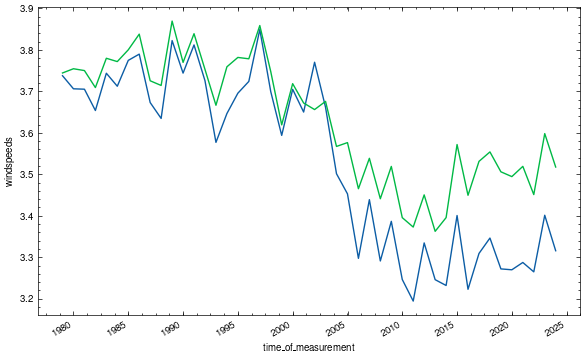

In [102]:
# Plots
fig, ax = plt.subplots(figsize=(7,4))
lower_48_1978.mean({'lat', 'lon'})['windspeeds'].resample(time='1Y').mean().plot(ax=ax, label="Kriged")
obs_1978.mean('station_id')['windspeeds'].resample(time='1Y').mean().plot(ax=ax, label="Observations")
plt.show()

## Plot of average wind speed over time (Panels)

In [ ]:
n_plots = len(states)+1
ncols = 2
nrows = int(np.ceil(n_plots/ncols))
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*7,nrows*4))
fig=plt.figure(figsize=(ncols*7,nrows*4))

gs=GridSpec(nrows, ncols) # 2 rows, 3 columns

# So each subplot has different color
colors = plt.rcParams["axes.prop_cycle"]()

# Get mean of all sites per state
for i, state in enumerate(state_ds.state):
    row = i//ncols
    col = i%ncols
    pax = fig.add_subplot(gs[row,col])
    # pax = ax.flatten()[i]
    state_means = state_ds.sel(state=state).mean(dim=["station_id"])
    state_roll = state_means.rolling(time=12).mean()
    state_means.windspeeds.plot(
        ax=pax, label="Monthly", alpha = 0.3, color="grey"
    )
    state_roll.windspeeds.plot(
        ax=pax, label="Annual", color=next(colors)["color"]
    )
    pax.set_title(state.values)
    # Remove x-label
    pax.set_xlabel("")
    pax.set_ylabel("Mean Wind Speed [m/s]")
    
# Add mean of all states
all_mean = state_ds.mean(dim=["station_id", "state"])
all_roll = all_mean.rolling(time=12).mean()#.resample(time="1Y").mean()#.rolling(time=36).mean()
# all_mean.windspeeds.plot(ax=ax, label="All NE", color="black")
# pax = ax.flatten()[-1]
pax = fig.add_subplot(gs[-1,:])
all_mean.windspeeds.plot(
    ax=pax, label="Monthly", alpha = 0.3, color="grey"
)
all_roll.windspeeds.plot(
    ax=pax, label="Annual", color="#808000"
)
pax.set_title("Combined")
# Add legend
# ax.legend()
# Add labels
pax.set_xlabel("Time")
pax.set_ylabel("Mean Wind Speed [m/s]")
plt.show()